Finalized Version of Workbook and Data used

In [ ]:
# Used Libaries

import pandas as pd
import matplotlib.pyplot as plt
import dpp.cc as cc

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
#Data import and cleaning


datetime_cols = ["call_started", "call_answered", "call_ended"]

df = pd.read_csv(
    "../data/raw/call-centre-queue-simulation/simulated_call_centre.csv",
    parse_dates=["date"]
)

# Remove 'call_id' column if it exists
if 'call_id' in df.columns:
    df = df.drop(columns=['call_id'])

time_format = "%I:%M:%S %p"  # Example: 01:23:45 PM
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], format=time_format)

# Remove rows with a service length of less then 10 or negative values
# Manuel check showes that cases with less then 10 seconds are not realistic.
# There are are around 150 Cases with wait time less then 10 seconds those are removed too.
mask_length = (df["call_ended"] - df["call_started"]).dt.total_seconds() >= 10
df = df[mask_length]

# Drop column daily_caller as it value is not needed for further analysis
# If needed can be calculated with groupby on date and count of calls
if 'daily_caller' in df.columns:
    df = df.drop(columns=['daily_caller'])  
  
#Calculate call duration in seconds and handling time in seconds
df["call_duration"] = (df["call_ended"] - df["call_answered"]).dt.total_seconds()
df["handling_time"] = (df["call_ended"] - df["call_started"]).dt.total_seconds()

#reset index after filtering
df = df.reset_index(drop=True)
display (df)
#display (df.dtypes)

,date,call_started,call_answered,call_ended,wait_length,service_length,meets_standard,call_duration,handling_time
0,2021-01-01,1900-01-01 08:00:00,1900-01-01 08:00:00,1900-01-01 08:14:22,0,863,True,862.0,862.0
1,2021-01-01,1900-01-01 08:02:42,1900-01-01 08:02:42,1900-01-01 08:07:31,0,289,True,289.0,289.0
2,2021-01-01,1900-01-01 08:08:24,1900-01-01 08:08:24,1900-01-01 08:10:13,0,108,True,109.0,109.0
3,2021-01-01,1900-01-01 08:09:37,1900-01-01 08:09:37,1900-01-01 08:13:45,0,247,True,248.0,248.0
4,2021-01-01,1900-01-01 08:11:10,1900-01-01 08:11:10,1900-01-01 08:15:28,0,258,True,258.0,258.0
...,...,...,...,...,...,...,...,...,...
50246,2021-12-31,1900-01-01 17:47:30,1900-01-01 17:47:30,1900-01-01 17:49:33,0,123,True,123.0,123.0
50247,2021-12-31,1900-01-01 17:50:10,1900-01-01 17:50:10,1900-01-01 17:57:26,0,436,True,436.0,436.0
50248,2021-12-31,1900-01-01 17:50:31,1900-01-01 17:50:31,1900-01-01 17:54:55,0,265,True,264.0,264.0
50249,2021-12-31,1900-01-01 17:51:29,1900-01-01 17:51:29,1900-01-01 17:54:26,0,177,True,177.0,177.0


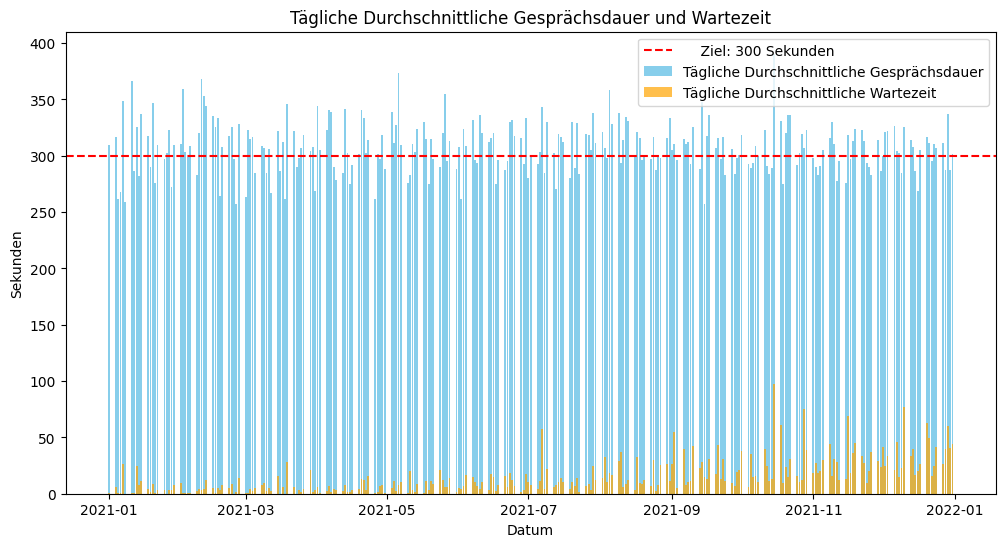

,date,call_started,call_answered,call_ended,wait_length,service_length,meets_standard,call_duration,handling_time
0,2021-01-01,1900-01-01 08:00:00,1900-01-01 08:00:00,1900-01-01 08:14:22,0,863,True,862.0,862.0
1,2021-01-01,1900-01-01 08:02:42,1900-01-01 08:02:42,1900-01-01 08:07:31,0,289,True,289.0,289.0
2,2021-01-01,1900-01-01 08:08:24,1900-01-01 08:08:24,1900-01-01 08:10:13,0,108,True,109.0,109.0
3,2021-01-01,1900-01-01 08:09:37,1900-01-01 08:09:37,1900-01-01 08:13:45,0,247,True,248.0,248.0
4,2021-01-01,1900-01-01 08:11:10,1900-01-01 08:11:10,1900-01-01 08:15:28,0,258,True,258.0,258.0
...,...,...,...,...,...,...,...,...,...
50246,2021-12-31,1900-01-01 17:47:30,1900-01-01 17:47:30,1900-01-01 17:49:33,0,123,True,123.0,123.0
50247,2021-12-31,1900-01-01 17:50:10,1900-01-01 17:50:10,1900-01-01 17:57:26,0,436,True,436.0,436.0
50248,2021-12-31,1900-01-01 17:50:31,1900-01-01 17:50:31,1900-01-01 17:54:55,0,265,True,264.0,264.0
50249,2021-12-31,1900-01-01 17:51:29,1900-01-01 17:51:29,1900-01-01 17:54:26,0,177,True,177.0,177.0


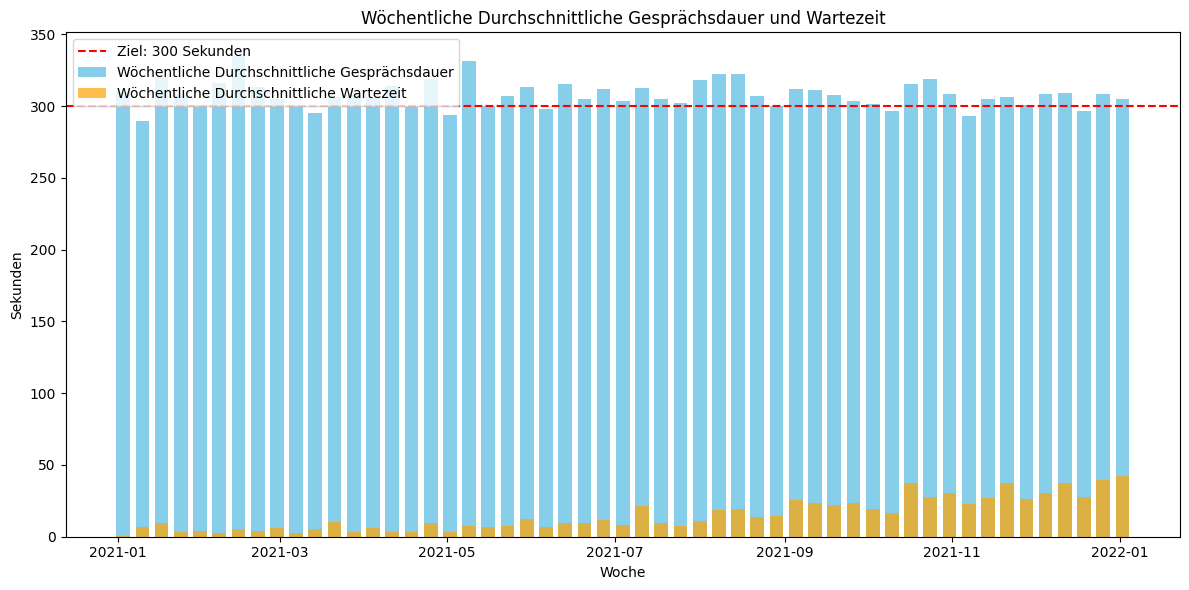

,meets_standard,service_level
date,,
2021-01-03,0.993007,99.300699
2021-01-10,0.973646,97.364568
2021-01-17,0.963068,96.306818
2021-01-24,0.977654,97.765363
2021-01-31,0.977134,97.713415
2021-02-07,0.990528,99.052774
2021-02-14,0.968839,96.883853
2021-02-21,0.975643,97.564276
2021-02-28,0.962868,96.286812


In [ ]:
#Current state of the data

# Calculate average call_duration for each day
daily_avg_wait_time = df.groupby('date')['wait_length'].mean().reset_index()
daily_avg_call_time = df.groupby('date')['call_duration'].mean().reset_index()
target_avg = 300  # Target average call duration in seconds

# Plot daily average call duration as bar chart with target line 
# Plot daily average wait time as bar chart
# Add horizontal line for target average call duration of 300 seconds
   
plt.figure(figsize=(12, 6))
plt.bar(daily_avg_call_time['date'], daily_avg_call_time['call_duration'], color='skyblue', label='Tägliche Durchschnittliche Gesprächsdauer')
plt.bar(daily_avg_wait_time['date'], daily_avg_wait_time['wait_length'], color='orange', label='Tägliche Durchschnittliche Wartezeit', alpha=0.7)

plt.axhline(y=target_avg, color='r', linestyle='--', label='    Ziel: 300 Sekunden')
plt.title('Tägliche Durchschnittliche Gesprächsdauer und Wartezeit') 
plt.xlabel('Datum')
plt.ylabel('Sekunden')   
plt.legend()
plt.show()  

# Time Series Analysis and Forecasting
# Focus on Service Level (SL) - percentage of calls answered within 60  seconds
# Calculate daily service level
daily_sl = df.groupby('date')['meets_standard'].mean().reset_index()
daily_sl['service_level'] = daily_sl['meets_standard'] * 100  # Convert to percentage
daily_sl = daily_sl.set_index('date')   

display(df)


# Calculate weekly average call_duration and wait_length
weekly_avg_call_time = df.resample('W', on='date')['call_duration'].mean().reset_index()
weekly_avg_wait_time = df.resample('W', on='date')['wait_length'].mean().reset_index()
target_avg = 300  # Target average call duration in seconds

# Plot weekly average call duration and wait time as bar chart
plt.figure(figsize=(12, 6))
plt.bar(weekly_avg_call_time['date'], weekly_avg_call_time['call_duration'], 
        width=5, color='skyblue', label='Wöchentliche Durchschnittliche Gesprächsdauer')
plt.bar(weekly_avg_wait_time['date'], weekly_avg_wait_time['wait_length'], 
        width=5, color='orange', label='Wöchentliche Durchschnittliche Wartezeit', alpha=0.7)

plt.axhline(y=target_avg, color='r', linestyle='--', label='Ziel: 300 Sekunden')
plt.title('Wöchentliche Durchschnittliche Gesprächsdauer und Wartezeit') 
plt.xlabel('Woche')
plt.ylabel('Sekunden')   
plt.legend()
plt.tight_layout()
plt.show()  

# Time Series Analysis and Forecasting
# Weekly service level (percentage of calls answered within 60 seconds)
weekly_sl = df.resample('W', on='date')['meets_standard'].mean().reset_index()
weekly_sl['service_level'] = weekly_sl['meets_standard'] * 100  # Convert to percentage
weekly_sl = weekly_sl.set_index('date')   

display(weekly_sl)



C:\Users\avtma\AppData\Local\Temp\ipykernel_9156\2104149477.py:35: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_3_months_avg = ts_calls.last('90D').mean()


Average calls in the last 3 months: 248.9
Average historical service level: 92.7%


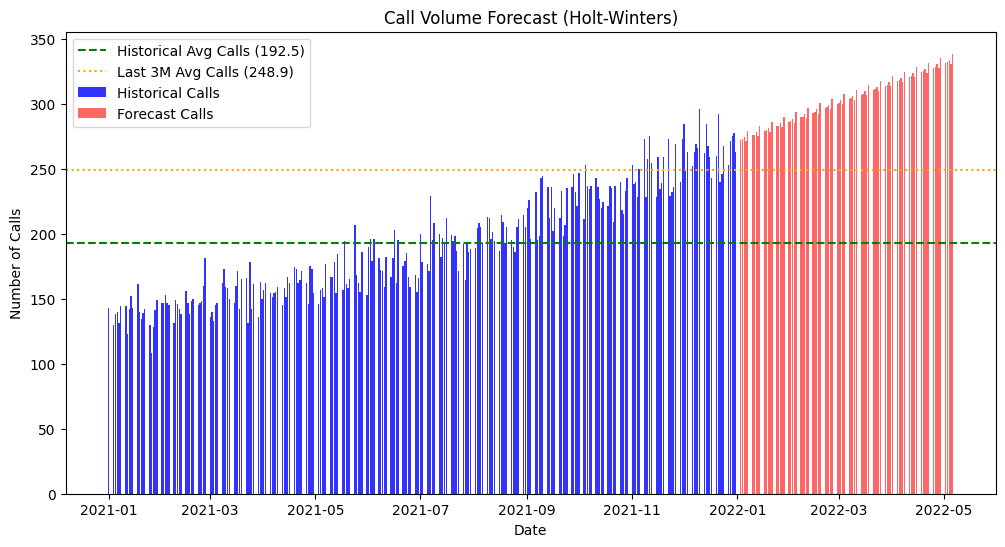

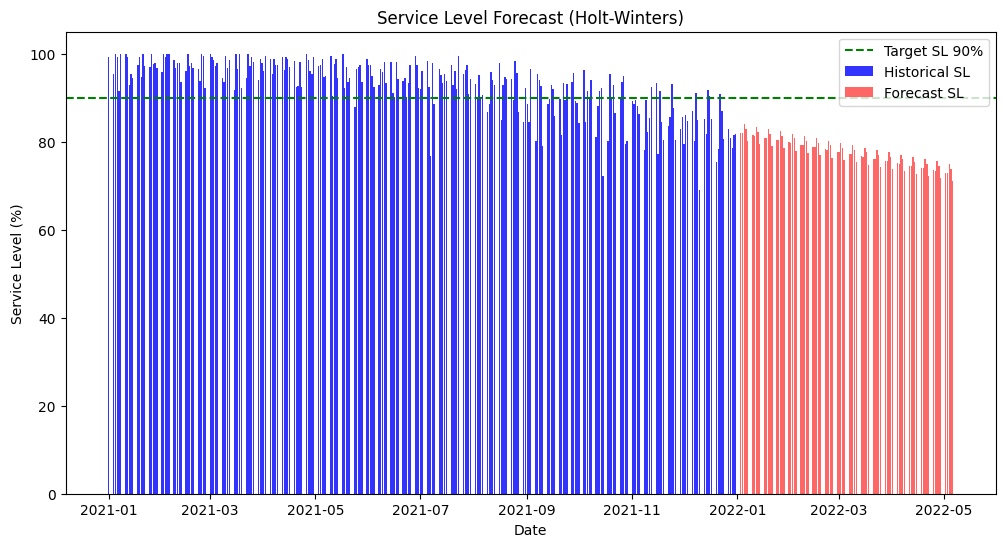

In [4]:
#Trend analysis of required agents based on forecasted service level and call volume
# Predicted call volume based on historical averages for the next 90 days
# Create bar chart for better visibility

# Tagesaggregation: Anzahl angenommener Anrufe pro Tag
# Daily aggregation: number of answered calls per day (via call_started)
forcast_days = 90
week_days    = 5

df["answered_within_60s"] = (df["wait_length"] <= 60).astype(int)
agg = (
    df.groupby("date")
    .agg(
        total_calls=("call_started", "count"),
        servicelevel=("answered_within_60s", "mean"),
    )
    .reset_index()
)

# Time series with explicit frequency (Business Day)
ts_calls = agg.set_index('date')['total_calls'].asfreq('B')
ts_sl = agg.set_index('date')['servicelevel'].asfreq('B') * 100  # in %

# Fit Holt-Winters models
model_calls = ExponentialSmoothing(ts_calls, trend="add", seasonal="add", seasonal_periods=week_days)
fit_calls = model_calls.fit()
forecast_calls = fit_calls.forecast(forcast_days)

model_sl = ExponentialSmoothing(ts_sl, trend="add", seasonal="add", seasonal_periods=week_days)
fit_sl = model_sl.fit()
forecast_sl = fit_sl.forecast(forcast_days)

# Calculate averages
avg_calls = ts_calls.mean()
last_3_months_avg = ts_calls.last('90D').mean()

# Print average servicelevel
avg_sl = ts_sl.mean()
print(f"Average calls in the last 3 months: {last_3_months_avg:.1f}")
print(f"Average historical service level: {avg_sl:.1f}%")

# Visualization Calls
plt.figure(figsize=(12,6))  
plt.bar(ts_calls.index, ts_calls, label="Historical Calls", color="blue", alpha=0.8)
plt.bar(forecast_calls.index, forecast_calls, label="Forecast Calls", color="red", alpha=0.6)
plt.axhline(avg_calls, color="green", linestyle="--", label=f"Historical Avg Calls ({avg_calls:.1f})")
plt.axhline(last_3_months_avg, color="orange", linestyle=":", label=f"Last 3M Avg Calls ({last_3_months_avg:.1f})")
plt.title("Call Volume Forecast (Holt-Winters)")
plt.xlabel("Date")
plt.ylabel("Number of Calls") 
plt.legend()
# plt.savefig("../data/processed/call_volume_forecast.png", dpi=300, bbox_inches="tight")
plt.show()

# Visualization Service Level
plt.figure(figsize=(12,6))  
plt.bar(ts_sl.index, ts_sl, label="Historical SL", color="blue", alpha=0.8)
plt.bar(forecast_sl.index, forecast_sl, label="Forecast SL", color="red", alpha=0.6)
plt.axhline(90, color="green", linestyle="--", label="Target SL 90%")
plt.title("Service Level Forecast (Holt-Winters)")
plt.xlabel("Date")
plt.ylabel("Service Level (%)") 
plt.legend()
# plt.savefig("../data/processed/servicelevel_forecast.png", dpi=300, bbox_inches="tight")
plt.show()


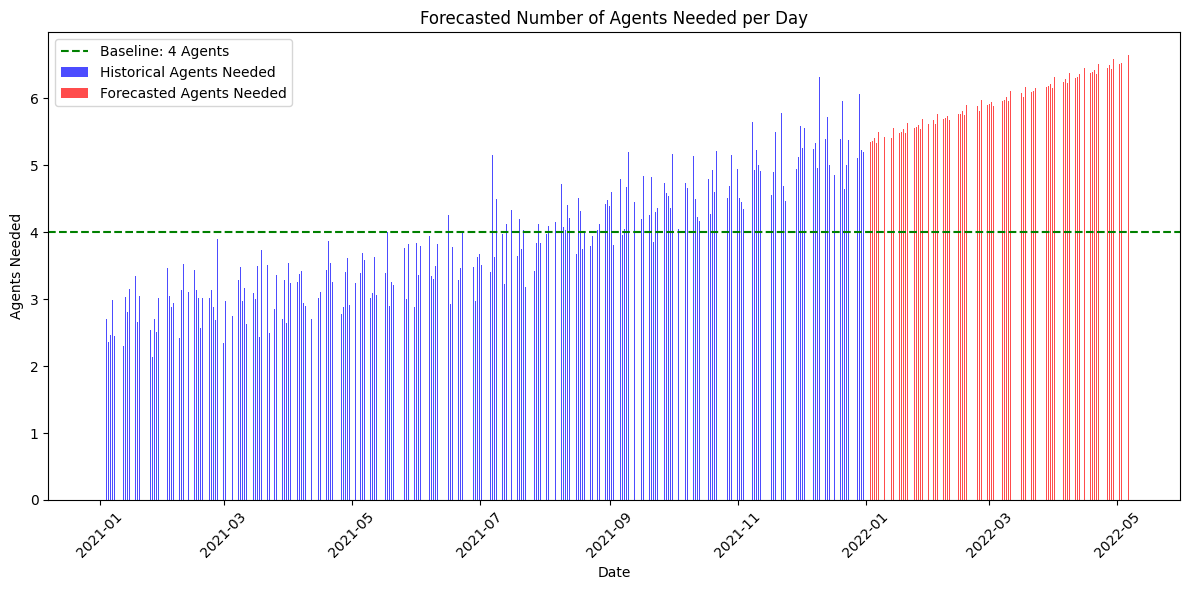

In [ ]:
# Workforce Planning
work_seconds_per_agent = 36000  # 10 hours shift
aht = 300  # Average Handling Time in seconds (5 minutes)


agg = df.groupby('date').agg(
                            total_calls=('call_started', 'count'),
                            total_within_60s=('meets_standard', lambda x: x.sum()),
                            total__service_time=('call_duration', 'sum')
                            )   

#display(agg)

util_agent = cc.utilization_with_target(agg=agg,
                                        target_sl=0.9,  # Target service level of 90%
                                        num_agents=4,  # Current number of agents
                                        work_seconds_per_agent=work_seconds_per_agent  # 8 hours shift
                                        )

#display(util_agent)  

agent_needed = forecast_calls.apply(
                                    lambda x: cc.compute_needed_agents(
                                                                        total_service_seconds=x * aht,  # Assuming average call duration of 300 seconds
                                                                        work_seconds_per_agent=work_seconds_per_agent,  # 8 hours shift
                                                                        target_utilization=util_agent
                                                                        )   
                                    )                        
# #display(forecast_calls)
                            
#display(agent_needed)
agg['agents_needed'] = agg['total__service_time'] / work_seconds_per_agent / util_agent

#display(agg)
plt.figure(figsize=(12,6))

# Historical agents
plt.bar(agg.index, agg['agents_needed'], width=0.4, label="Historical Agents Needed", color="blue", alpha=0.7)

# Forecasted agents, shifted slightly to avoid overlap
plt.bar(agent_needed.index + pd.Timedelta(days=0.2), agent_needed.values, width=0.4, label="Forecasted Agents Needed", color="red", alpha=0.7)

# Baseline line at 4 agents
plt.axhline(4, color='green', linestyle='--', label="Baseline: 4 Agents")

plt.xlabel("Date")
plt.ylabel("Agents Needed")
plt.title("Forecasted Number of Agents Needed per Day")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()